In [0]:
from google.colab import files
uploads=files.upload()

Saving tf_idf_df.pkl to tf_idf_df.pkl


In [0]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 70 Oct 17 15:20 kaggle.json


In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [0]:
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!pip install kaggle

In [0]:
!kaggle datasets download -d snap/amazon-fine-food-reviews
#!kaggle competitions download -c tgs-salt-identification-challenge

 96% 241M/251M [00:04<00:00, 48.4MB/s]
100% 251M/251M [00:04<00:00, 56.7MB/s]


In [0]:
import zipfile
zip_ref = zipfile.ZipFile("amazon-fine-food-reviews.zip", 'r')
zip_ref.extractall("amazon")
zip_ref.close()

In [0]:
!pip install gensim

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3

import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle



#Data Preprocessing

In [0]:
con = sqlite3.connect('amazon/database.sqlite')

In [0]:
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con)

In [0]:
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

In [0]:
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [0]:
print(filtered_data.shape) #looking at the number of attributes and size of the data
filtered_data.head()

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [0]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [0]:
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
final['Score'].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [0]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:

stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english')

def cleanhtml(sentence): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned


In [0]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) 
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) 
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence)
    
    
    final_string.append(str1)
    i+=1

In [0]:
len(filtered_sentence)

30

In [0]:
len(final_string)

364171

In [0]:
final['CleanedText']=final_string 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [0]:
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [0]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


In [0]:
final['Score'].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [0]:
sampled_data1=final[final['Score']=='negative'].head(10000)

In [0]:
sampled_data2=final[final['Score']=='positive'].head(10000)

In [0]:
sampled_data= pd.concat([sampled_data1,sampled_data2])

In [0]:
sampled_data.shape

(20000, 11)

In [0]:
sampled_data=sampled_data.sort_values(by='Time')

In [0]:
sampled_data.tail()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
502140,542900,B0001HAEJY,A289SYWE4BHCF,akilah,0,0,positive,1351209600,Great!,"Very good product, great for your blood! You w...",good product great blood love aim wonder produ...
192892,209140,B00004RAMY,AEQ2FUEQEQVTI,heathcliff,0,0,negative,1351209600,defective device,no instructions provided. Trap would not open....,instruct provid trap would open tri set trap c...
106073,115167,B0001HAEKI,A289SYWE4BHCF,akilah,0,0,positive,1351209600,Good stuff,"Very good product, helps with a lot of ailment...",good product help lot ailment great help stock...
157913,171229,7310172001,A3SSEJ8IEM4YGW,Seagaul,0,0,positive,1351209600,Dogs love it.,"This is the ""all gone"" treat after dinner. It...",gone treat dinner treat dog work run chanc los...
307489,333012,B0000CFXYA,A3GS4GWPIBV0NT,"R. Chester ""ricki1966""",0,0,negative,1351209600,Strange inflammation response,Truthfully wasn't crazy about the taste of the...,truth wasnt crazi tast reason low rate post he...


In [0]:
sampled_data.to_pickle('sampled_data.pkl')

In [0]:
sampled_data=pd.read_pickle('sampled_data.pkl')

In [0]:
sampled_data=sampled_data.head(5000)

In [0]:
sampled_data['Score'].value_counts()

positive    2957
negative    2043
Name: Score, dtype: int64

# Bag of Words

In [0]:
count_vect = CountVectorizer()
bag_of_words = count_vect.fit_transform(sampled_data['CleanedText'].values)
print("the type of count vectorizer ",type(bag_of_words))
print("the shape of out text BOW vectorizer ",bag_of_words.get_shape())
print("the number of unique words ", bag_of_words.get_shape()[1])

In [0]:
type(bag_of_words)

scipy.sparse.csr.csr_matrix

In [0]:
petplexity_vals=[2,10,30,50,100]

In [0]:
y=np.array(sampled_data['Score'])

In [0]:
y.shape

(5000,)

In [0]:
bag_of_words.shape

(5000, 10844)

In [0]:
from sklearn.manifold import TSNE
import seaborn as sns

Tnse for perplexity value 2 and itrations =1000


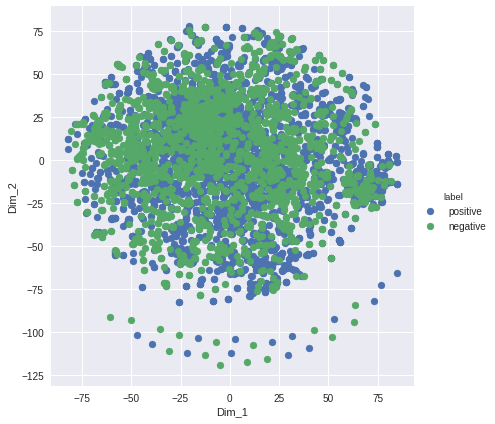

Tnse for perplexity value 10 and itrations =1000


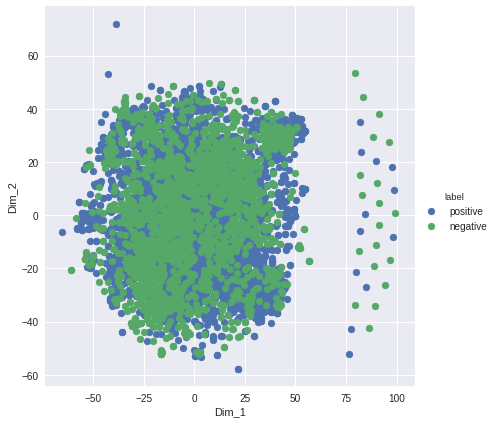

Tnse for perplexity value 30 and itrations =1000


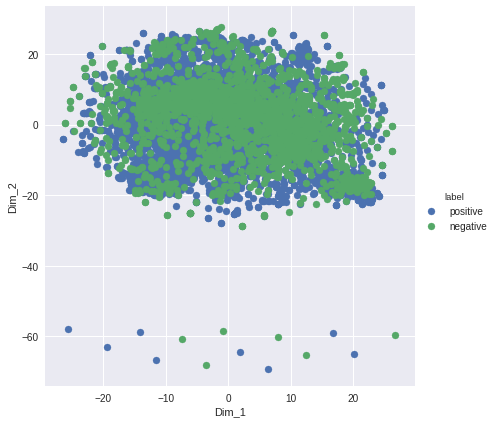

Tnse for perplexity value 50 and itrations =1000


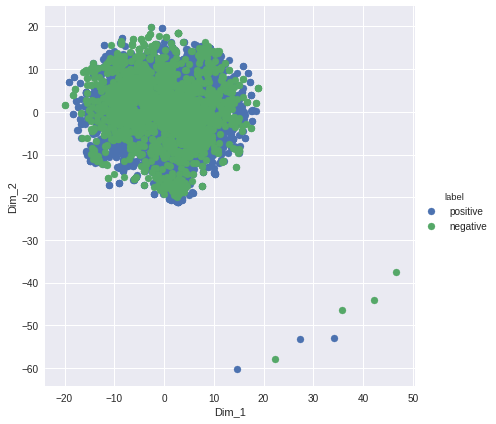

Tnse for perplexity value 100 and itrations =1000


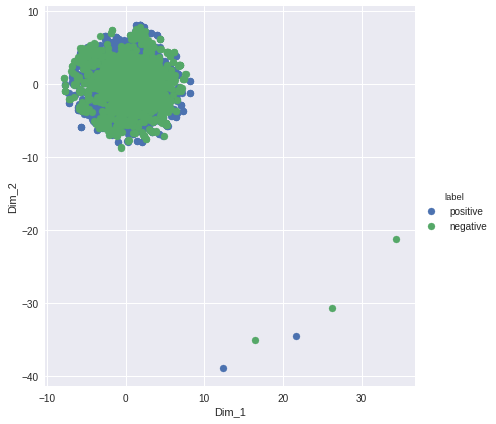

In [0]:
data =bag_of_words 
labels = y

for petplexity in petplexity_vals:
  model = TSNE(n_components=2,perplexity=float(petplexity),random_state=0)
  tsne_data = model.fit_transform(data.toarray())
  print('Tnse for perplexity value {} and itrations =1000'.format(petplexity))
  tsne_data = np.vstack((tsne_data.T, labels)).T
  tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
  sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
  plt.show()

#TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(sampled_data['CleanedText'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (5000, 140422)
the number of unique words including both unigrams and bigrams  140422


In [0]:
final_tf_idf.shape

(5000, 10844)

In [0]:
y=np.array(sampled_data['Score'])

In [0]:
petplexity_vals=[30,50]

In [0]:
from sklearn.manifold import TSNE
import seaborn as sns

Tnse for perplexity value 30 and itrations =1000


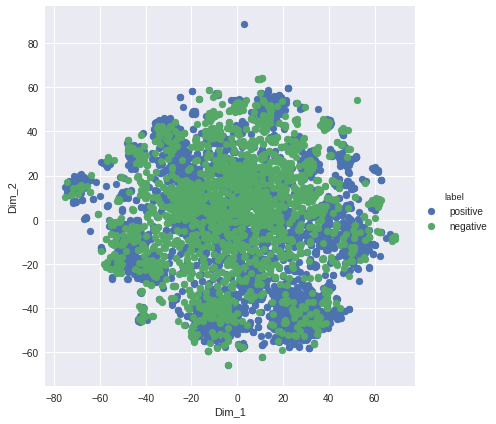

Tnse for perplexity value 50 and itrations =1000


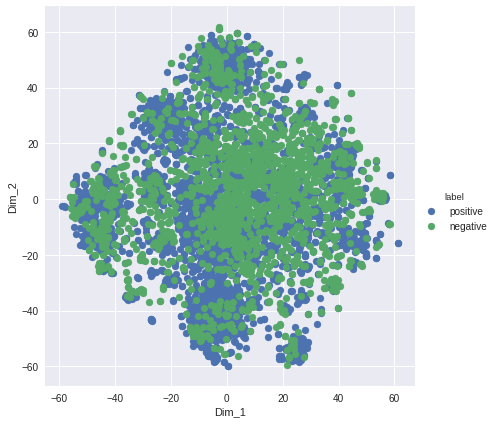

In [0]:
data =final_tf_idf 
labels = y

for petplexity in petplexity_vals:
  model = TSNE(n_components=2,perplexity=float(petplexity),random_state=0)
  tsne_data = model.fit_transform(data.toarray())
  print('Tnse for perplexity value {} and itrations =1000'.format(petplexity))
  tsne_data = np.vstack((tsne_data.T, labels)).T
  tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
  sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
  plt.show()

# Word to Vec

In [0]:
i=0
list_of_sent=[]
for sent in sampled_data['CleanedText'].values:
    list_of_sent.append(sent.split())

In [0]:
len(list_of_sent)

5000

In [0]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3584
sample words  ['littl', 'book', 'make', 'son', 'laugh', 'loud', 'car', 'drive', 'along', 'alway', 'sing', 'hes', 'learn', 'india', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'bet', 'still', 'abl', 'memori', 'colleg', 'rememb', 'see', 'show', 'air', 'televis', 'year', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirti', 'someth', 'use', 'seri', 'song', 'student', 'teach', 'turn', 'whole', 'school', 'purchas', 'children']


In [0]:
type(w2v_model)

gensim.models.word2vec.Word2Vec

# AVG WORD2VEC

In [0]:
sent_vectors = []
for sent in list_of_sent:
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)


In [0]:
print(len(sent_vectors))
print(len(sent_vectors[0]))

5000
50


In [0]:
type(sent_vectors)

list

In [0]:
sent_vectors[0]

array([-0.19462437,  0.23340476, -0.17858542,  0.05876136, -0.27762264,
        0.07328378,  0.17187935,  0.30621421, -0.12531681, -0.4138404 ,
        0.38436232,  0.33665943,  0.30274915, -0.20020761, -0.0930834 ,
        0.33172089, -0.46540115, -0.58085452, -0.07600536,  0.02576449,
       -0.38356153, -0.08933746,  0.16084748,  0.0630368 ,  0.08941781,
        0.29359079,  0.18794671, -0.00184417, -0.12284827, -0.28394224,
       -0.33227237,  0.25164672, -0.4659577 , -0.34439139,  0.03844065,
        0.38026908,  0.07189817, -0.29150311,  0.03099778, -0.09563734,
        0.323942  ,  0.0589561 , -0.42353987, -0.37194246, -0.2844572 ,
        0.46048908, -0.17896475, -0.18609697,  0.6635312 , -0.46209171])

In [0]:
petplexity_vals=[2,30,50,100]

Tnse for perplexity value 2 and itrations =1000


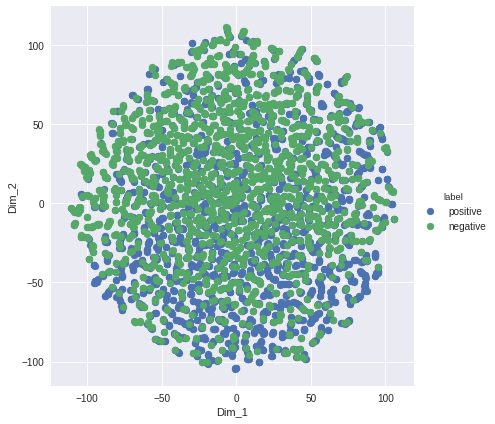

Tnse for perplexity value 30 and itrations =1000


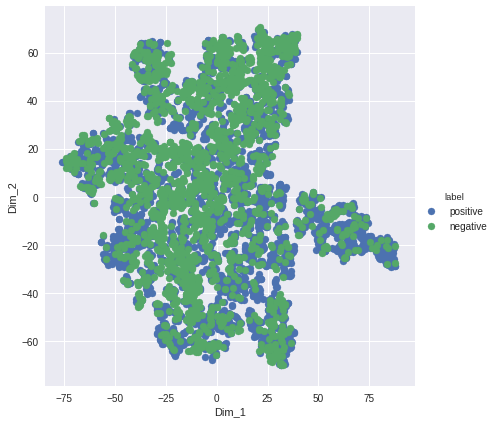

Tnse for perplexity value 50 and itrations =1000


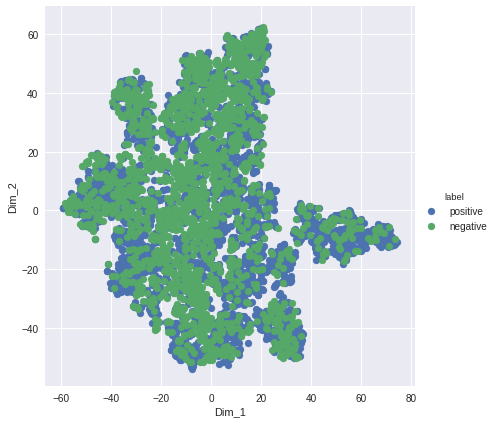

Tnse for perplexity value 100 and itrations =1000


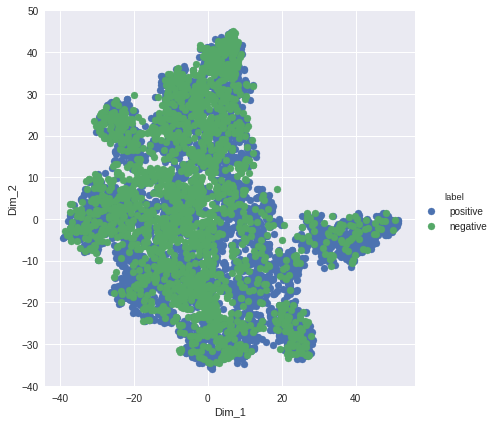

In [0]:
data =sent_vectors 
labels = y

for petplexity in petplexity_vals:
  model = TSNE(n_components=2,perplexity=float(petplexity),random_state=0)
  tsne_data = model.fit_transform(data)
  print('Tnse for perplexity value {} and itrations =1000'.format(petplexity))
  tsne_data = np.vstack((tsne_data.T, labels)).T
  tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
  sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
  plt.show()

# TF-IDF Word2Vec

In [0]:
tfidf_feat = tf_idf_vect.get_feature_names()

In [0]:
tfidf_sent_vectors = []
row=0;
for sent in list_of_sent: 
    sent_vec = np.zeros(50)
    weight_sum =0
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]            
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf       
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [0]:
random_data[10]

In [0]:
tfidf_sent_vectors=pd.read_pickle('tf_idf_df.pkl')


In [0]:
tf_idf=np.array(tfidf_sent_vectors)
tfidf_sent_vectors=tf_idf[0:5000,:]

In [0]:
tfidf_sent_vectors.shape

(5000, 50)

Tnse for perplexity value 2 and itrations =1000


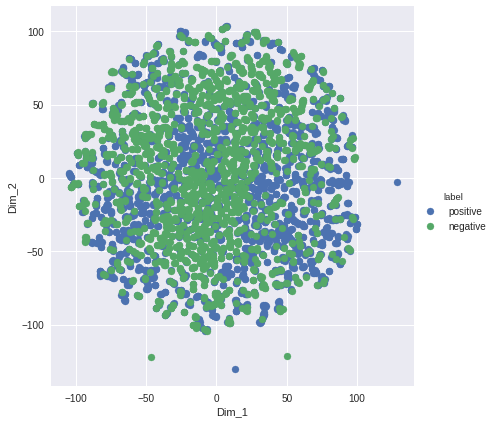

Tnse for perplexity value 30 and itrations =1000


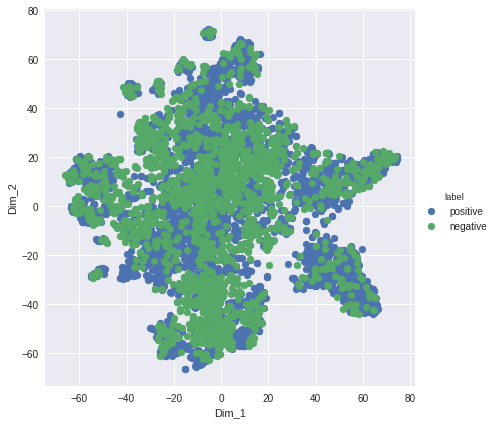

Tnse for perplexity value 50 and itrations =1000


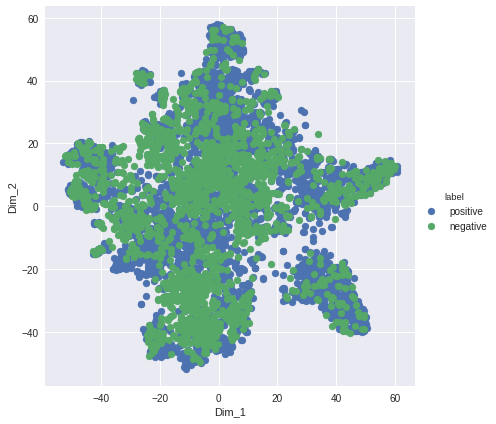

Tnse for perplexity value 100 and itrations =1000


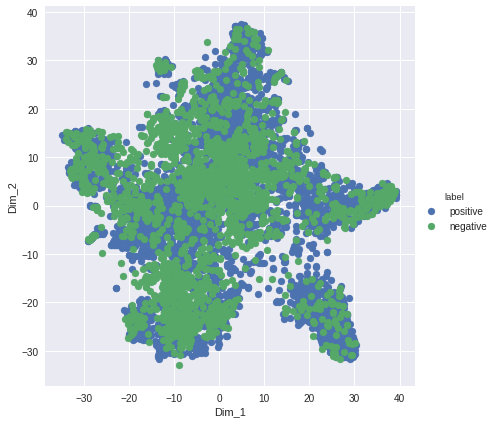

In [0]:
data =tfidf_sent_vectors 
labels = y

for petplexity in petplexity_vals:
  model = TSNE(n_components=2,perplexity=float(petplexity),random_state=0)
  tsne_data = model.fit_transform(data)
  print('Tnse for perplexity value {} and itrations =1000'.format(petplexity))
  tsne_data = np.vstack((tsne_data.T, labels)).T
  tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
  sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
  plt.show()